In [13]:
import pandas as pd

# Cargar el archivo Excel
file_path = './data/orders_orders.xlsx'
df = pd.read_excel(file_path)

# Verificar las columnas disponibles
print(df.head())

# Asegurarnos de que 'Order Date' esté en formato datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Verificar los años en los datos
print(df['Order Date'].dt.year.value_counts())


          Category           City   Country Customer ID    Customer Name  \
0  Office Supplies    Constantine   Algeria   TB-112801  Toby Braunhardt   
1  Office Supplies  Dar es Salaam  Tanzania    JG-51151       Jack Garza   
2  Office Supplies       Khartoum     Sudan    JC-53401  Jasper Cacioppo   
3  Office Supplies       Khartoum     Sudan    JC-53401  Jasper Cacioppo   
4       Technology         Luanda    Angola    GK-46201      Grace Kelly   

  Market Order Date      Order ID Order Priority        Product ID  ...  \
0   EMEA 2011-01-01  AG-2011-2040         Medium  OFF-TEN-10000025  ...   
1   EMEA 2011-01-03  TZ-2011-7370         Medium  OFF-STI-10000388  ...   
2   EMEA 2011-01-04  SU-2011-5190         Medium  OFF-BOS-10004950  ...   
3   EMEA 2011-01-04  SU-2011-5190         Medium  OFF-AVE-10003279  ...   
4   EMEA 2011-01-06  AO-2011-4910         Medium  TEC-LOG-10003079  ...   

   Ship Date       Ship Mode          State Sub-Category Discount  \
0 2011-01-06  Standard 

In [14]:
# Calcular el sumatorio diario de ventas
daily_sales = df.groupby('Order Date')['Sales'].sum()

# Filtrar días con sumatorio diario de ventas menor que 10
low_sales_days = daily_sales[daily_sales < 10]

# Contar el número de días con sumatorio bajo
num_low_sales_days = low_sales_days.shape[0]
print(f'Número de días con ventas diarias por debajo de 10: {num_low_sales_days}')

# Listar los días con sumatorio diario bajo
print('Días con ventas diarias por debajo de 10:')
print(low_sales_days)


Número de días con ventas diarias por debajo de 10: 1
Días con ventas diarias por debajo de 10:
Order Date
2011-02-06    2.688
Name: Sales, dtype: float64


In [15]:
# Filtrar datos de train y test
train = df[(df['Order Date'].dt.year >= 2011) & (df['Order Date'].dt.year <= 2013)]
test = df[df['Order Date'].dt.year == 2014]

# Resamplear los datos de train a nivel diario
# Asegurarse de que 'Sales' sea numérico
train['Sales'] = pd.to_numeric(train['Sales'], errors='coerce')

# Resamplear los datos para obtener la suma diaria
train_daily = train.set_index('Order Date').resample('D')['Sales'].sum()

# Mostrar un resumen de los datos resampleados
print(train_daily.head())



Order Date
2011-01-01     808.56300
2011-01-02     314.22000
2011-01-03    4503.53720
2011-01-04    2808.87024
2011-01-05    3662.31000
Freq: D, Name: Sales, dtype: float64


C:\Users\Guillem\AppData\Local\Temp\ipykernel_6260\350262817.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Sales'] = pd.to_numeric(train['Sales'], errors='coerce')


In [16]:
test_daily= test.set_index('Order Date').resample('D')['Sales'].sum()
print(test_daily.head())

Order Date
2014-01-01     3614.03450
2014-01-02     4169.51614
2014-01-03    11327.62200
2014-01-04     4705.27370
2014-01-05      426.66000
Freq: D, Name: Sales, dtype: float64


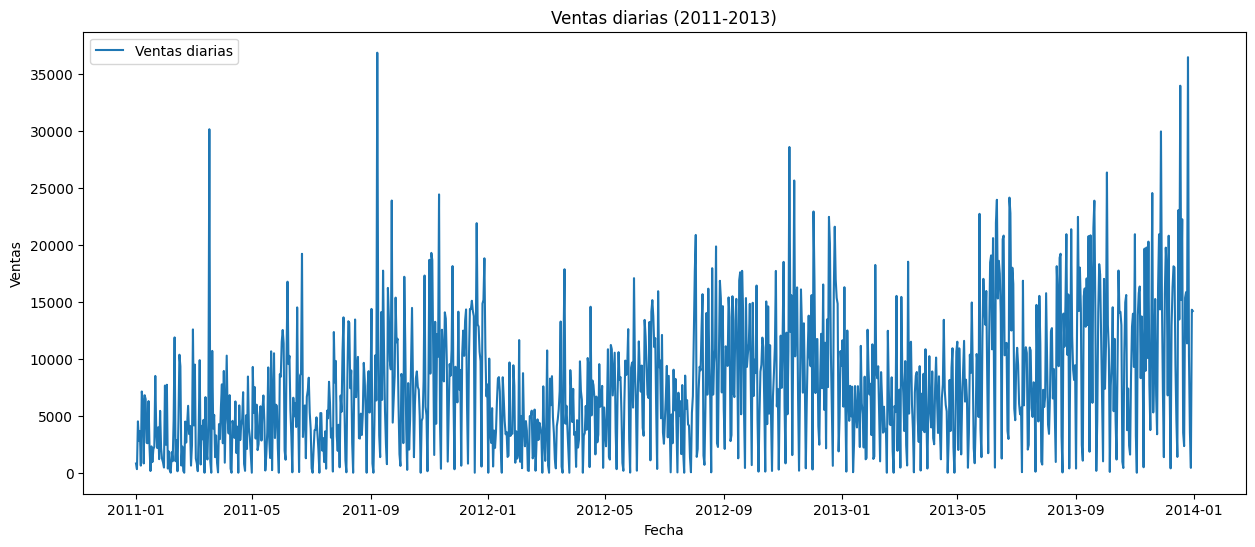

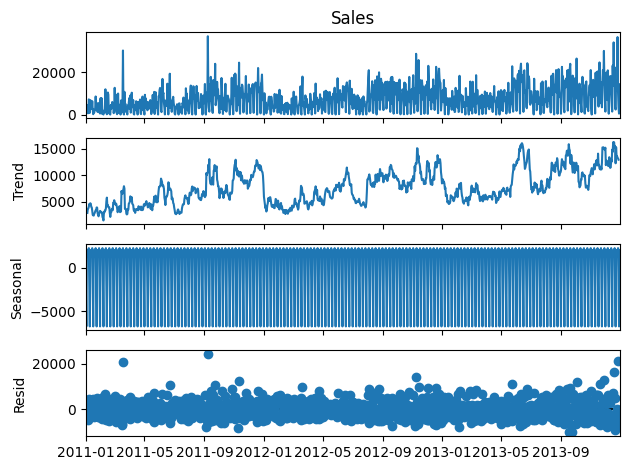

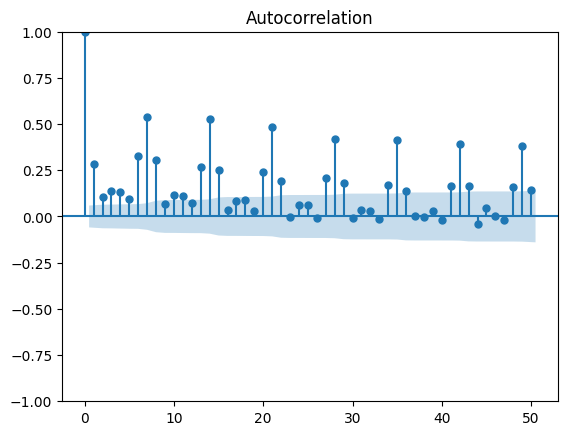

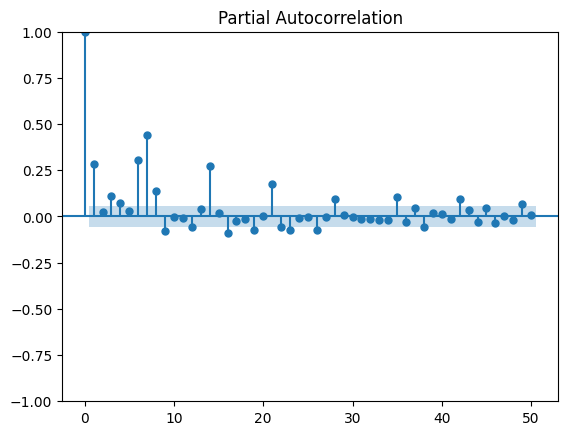

In [17]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Graficar la curva de ventas
plt.figure(figsize=(15, 6))
plt.plot(train_daily, label='Ventas diarias')
plt.title('Ventas diarias (2011-2013)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

# Descomponer en tendencia, estacionalidad y residuo
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result = seasonal_decompose(train_daily, model='additive')
decompose_result.plot()
plt.show()

# Gráficos de autocorrelación y autocorrelación parcial
plot_acf(train_daily, lags=50)
plt.show()

plot_pacf(train_daily, lags=50)
plt.show()


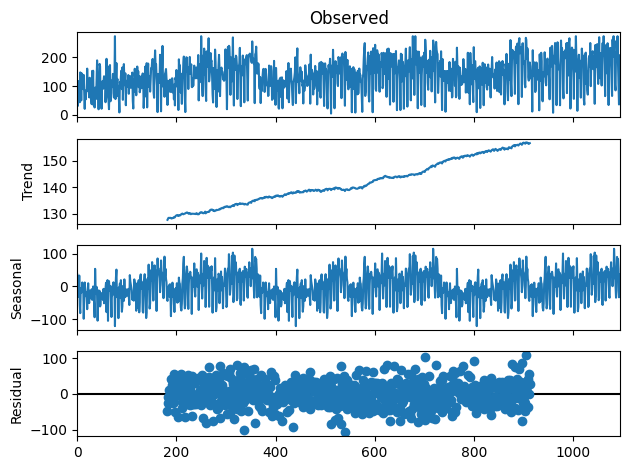

In [18]:
# Paso 1: Identificar y manejar valores atípicos
threshold_upper = train_daily.mean() + 3 * train_daily.std()
threshold_lower = 0  # Consideramos valores por debajo de 0 como errores

# Reemplazar valores atípicos por el límite superior
train_daily_clipped = train_daily.clip(lower=threshold_lower, upper=threshold_upper)

# Paso 2: Imputar valores bajos o nulos
# Identificar días con ventas bajas
low_sales_days = train_daily_clipped[train_daily_clipped < 10]

# Imputar con la media móvil de 7 días
train_daily_imputed = train_daily_clipped.copy()
train_daily_imputed[low_sales_days.index] = train_daily_clipped.rolling(window=7, min_periods=1).mean()[low_sales_days.index]

# Paso 3: Transformar los datos (opcional)
from scipy.stats import boxcox
train_daily_transformed, lmbda = boxcox(train_daily_imputed + 1)  # Sumar 1 para evitar log(0)

# Paso 4: Recalcular la descomposición estacional
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed_adjusted = seasonal_decompose(train_daily_transformed, model='additive', period=365)
decomposed_adjusted.plot()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(train_daily.dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])


AttributeError: 'numpy.ndarray' object has no attribute 'dropna'

In [19]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# ARIMA
arima_model = ARIMA(train_daily_transformed, order=(2, 1, 2)).fit()
print(arima_model.summary())

# SARIMA con auto_arima
sarima_model = auto_arima(train_daily_transformed, seasonal=True, m=12, trace=True, stepwise=True)
print(sarima_model.summary())


c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1096
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -5897.379
Date:                Mon, 18 Nov 2024   AIC                          11804.758
Time:                        20:17:57   BIC                          11829.751
Sample:                             0   HQIC                         11814.215
                               - 1096                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7409      0.063     11.703      0.000       0.617       0.865
ar.L2         -0.2864      0.034     -8.459      0.000      -0.353      -0.220
ma.L1         -1.6337      0.061    -26.778      0.0

In [21]:
# Paso 1: Identificar y manejar valores atípicos
threshold_upper = test_daily.mean() + 3 * train_daily.std()
threshold_lower = 0  # Consideramos valores por debajo de 0 como errores

# Reemplazar valores atípicos por el límite superior
test_daily_clipped = test_daily.clip(lower=threshold_lower, upper=threshold_upper)

# Paso 2: Imputar valores bajos o nulos
# Identificar días con ventas bajas
low_sales_days = test_daily_clipped[test_daily_clipped < 10]

# Imputar con la media móvil de 7 días
test_daily_imputed = test_daily_clipped.copy()
test_daily_imputed[low_sales_days.index] = test_daily_imputed.rolling(window=7, min_periods=1).mean()[low_sales_days.index]

# Paso 3: Transformar los datos (opcional)
from scipy.stats import boxcox
test_daily_transformed, lmbda = boxcox(test_daily_imputed + 1)  # Sumar 1 para evitar log(0)

# Paso 4: Recalcular la descomposición estacional
from statsmodels.tsa.seasonal import seasonal_decompose


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predicción ARIMA
arima_forecast = arima_model.forecast(steps=len(test))
arima_rmse = np.sqrt(mean_squared_error(test['Sales'], arima_forecast))
print('ARIMA RMSE:', arima_rmse)

# Predicción SARIMA
sarima_forecast = sarima_model.predict(n_periods=len(test_daily))
sarima_rmse = np.sqrt(mean_squared_error(test['Sales'], sarima_forecast))
print('SARIMA RMSE:', sarima_rmse)


ValueError: Found input variables with inconsistent numbers of samples: [17531, 365]

In [12]:
from pmdarima.model_selection import train_test_split

# Dividir train en sub-train y validación
sub_train, sub_test = train_test_split(train_daily, test_size=0.2)

# Validación cruzada para SARIMA
grid_search = auto_arima(sub_train, seasonal=True, m=12, stepwise=True,
                         start_p=0, start_q=0, max_p=5, max_q=5,
                         start_P=0, start_Q=0, max_P=2, max_Q=2,
                         D=1, max_D=2, trace=True)
print(grid_search.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=17803.795, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=17563.735, Time=0.77 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.38 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=17801.955, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=17799.961, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=17471.290, Time=1.62 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.66 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.91 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=17389.621, Time=11.74 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=17585.973, Time=0.70 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=17404.030, Time=2.55 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=17255.538, Time=4.68 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=1.59 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=12.45 sec
 ARIMA(0,0,0)(0,1,2)[12] intercep

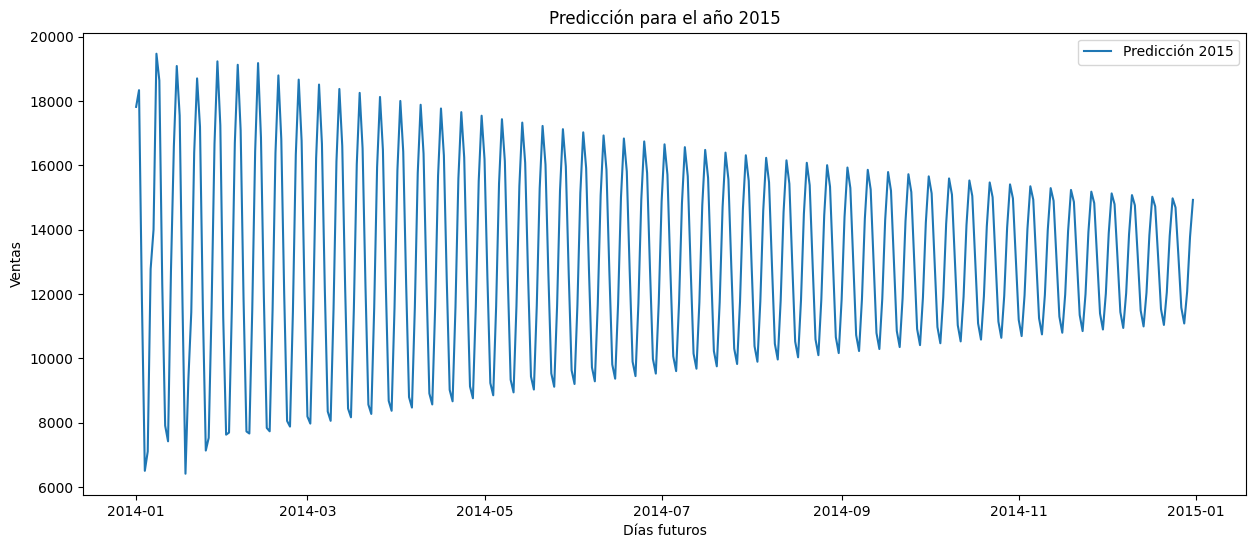

In [13]:
future_forecast = sarima_model.predict(n_periods=365)  # 365 días de predicción
plt.figure(figsize=(15, 6))
plt.plot(future_forecast, label='Predicción 2015')
plt.title('Predicción para el año 2015')
plt.xlabel('Días futuros')
plt.ylabel('Ventas')
plt.legend()
plt.show()


In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar el modelo SARIMA con los mejores parámetros
sarima_model = SARIMAX(train_daily, 
                       order=(0, 0, 0), 
                       seasonal_order=(1, 1, 1, 12), 
                       trend='c', 
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

sarima_fit = sarima_model.fit(disp=False)

# Resumen del modelo ajustado
print(sarima_fit.summary())


                                 SARIMAX Results                                  
Dep. Variable:                      Sales   No. Observations:                 1096
Model:             SARIMAX(1, 1, [1], 12)   Log Likelihood              -10881.109
Date:                    Sun, 17 Nov 2024   AIC                          21770.219
Time:                            19:30:29   BIC                          21790.124
Sample:                        01-01-2011   HQIC                         21777.759
                             - 12-31-2013                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     98.6242     26.649      3.701      0.000      46.394     150.855
ar.S.L12      -0.0384      0.059     -0.656      0.512      -0.153       0.076
ma.S.L12      -0.930

In [15]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predicción para el periodo de prueba (2014)
forecast_test = sarima_fit.get_forecast(steps=len(test))
forecast_mean = forecast_test.predicted_mean

# Calcular RMSE para el conjunto de prueba
rmse_test = np.sqrt(mean_squared_error(test.set_index('Order Date')['Sales'], forecast_mean))
print(f'RMSE del modelo SARIMA en el conjunto de prueba: {rmse_test}')


RMSE del modelo SARIMA en el conjunto de prueba: 90227.08613259943


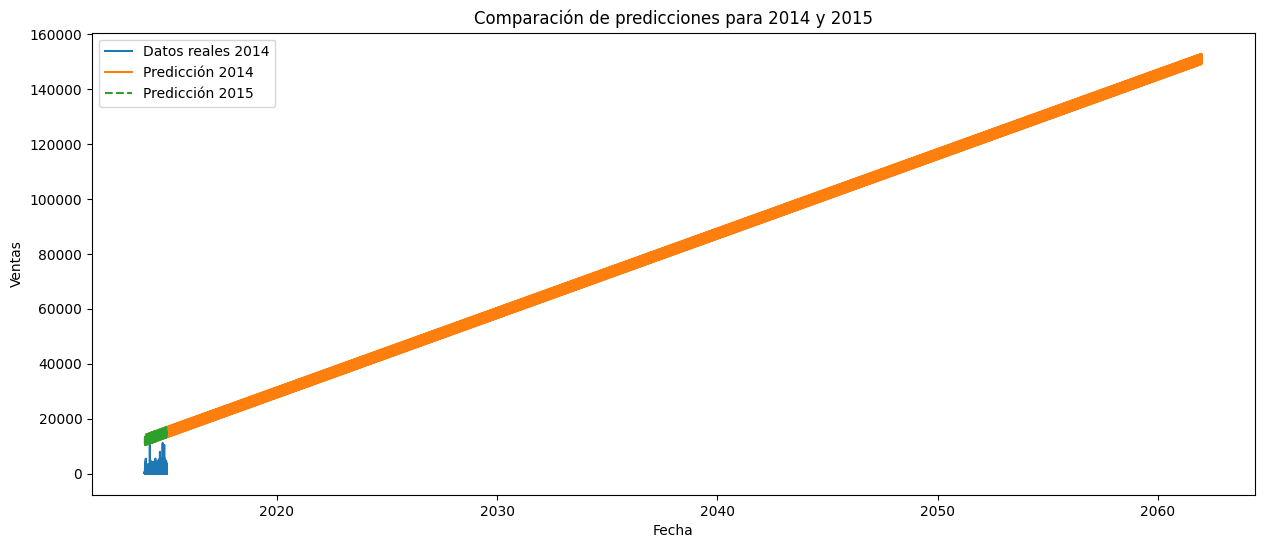

In [16]:
# Predicción extendida para 2015
forecast_2015 = sarima_fit.get_forecast(steps=365)  # 365 días para 2015
forecast_2015_mean = forecast_2015.predicted_mean

# Graficar las predicciones
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(test.set_index('Order Date')['Sales'], label='Datos reales 2014')
plt.plot(forecast_mean, label='Predicción 2014')
plt.plot(forecast_2015_mean, label='Predicción 2015', linestyle='--')
plt.title('Comparación de predicciones para 2014 y 2015')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()


In [17]:
# Agregar columna de año a los datos originales
df['Year'] = df['Order Date'].dt.year

# Sumar las ventas anuales reales
real_annual_sales = df.groupby('Year')['Sales'].sum()
print('Cifras anuales reales:')
print(real_annual_sales)

# Sumar las ventas anuales predichas
# Para el conjunto de prueba (2014)
pred_annual_sales_2014 = forecast_mean.sum()
print(f'Cifra anual predicha para 2014: {pred_annual_sales_2014}')

# Para el año 2015
pred_annual_sales_2015 = forecast_2015_mean.sum()
print(f'Cifra anual predicha para 2015: {pred_annual_sales_2015}')


Cifras anuales reales:
Year
2011    2.259451e+06
2012    2.677439e+06
2013    3.405746e+06
2014    4.299866e+06
Name: Sales, dtype: float64
Cifra anual predicha para 2014: 1421418796.5983331
Cifra anual predicha para 2015: 4797865.545495471


In [18]:
# Configurar pandas para mostrar números en formato normal
pd.options.display.float_format = '{:,.2f}'.format

# Sumar las ventas anuales reales
real_annual_sales = df.groupby('Year')['Sales'].sum()
print('Cifras anuales reales:')
print(real_annual_sales)

# Sumar las ventas anuales predichas
# Para el conjunto de prueba (2014)
pred_annual_sales_2014 = forecast_mean.sum()
print(f'Cifra anual predicha para 2014: {pred_annual_sales_2014:,.2f}')

# Para el año 2015
pred_annual_sales_2015 = forecast_2015_mean.sum()
print(f'Cifra anual predicha para 2015: {pred_annual_sales_2015:,.2f}')


Cifras anuales reales:
Year
2011   2,259,450.90
2012   2,677,438.69
2013   3,405,746.45
2014   4,299,865.87
Name: Sales, dtype: float64
Cifra anual predicha para 2014: 1,421,418,796.60
Cifra anual predicha para 2015: 4,797,865.55


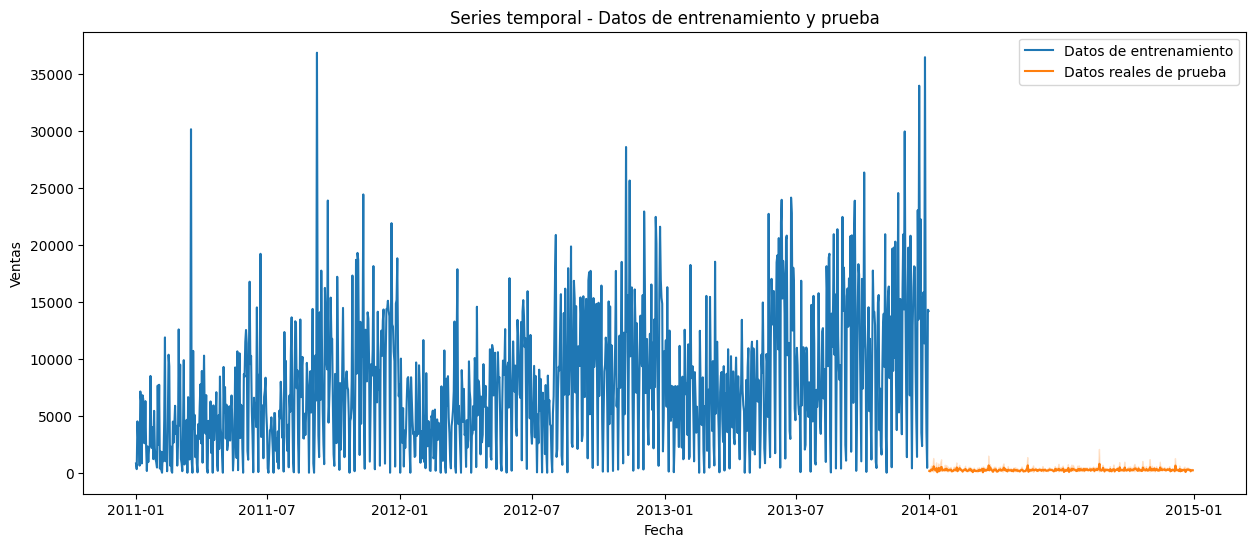

Valores atípicos detectados: Order Date
2011-03-18   30,117.55
2011-09-08   36,827.75
2012-11-08   28,561.16
2012-11-13   25,621.95
2013-10-03   26,325.30
2013-11-28   29,925.35
2013-12-18   33,934.38
2013-12-26   36,435.14
Name: Sales, dtype: float64


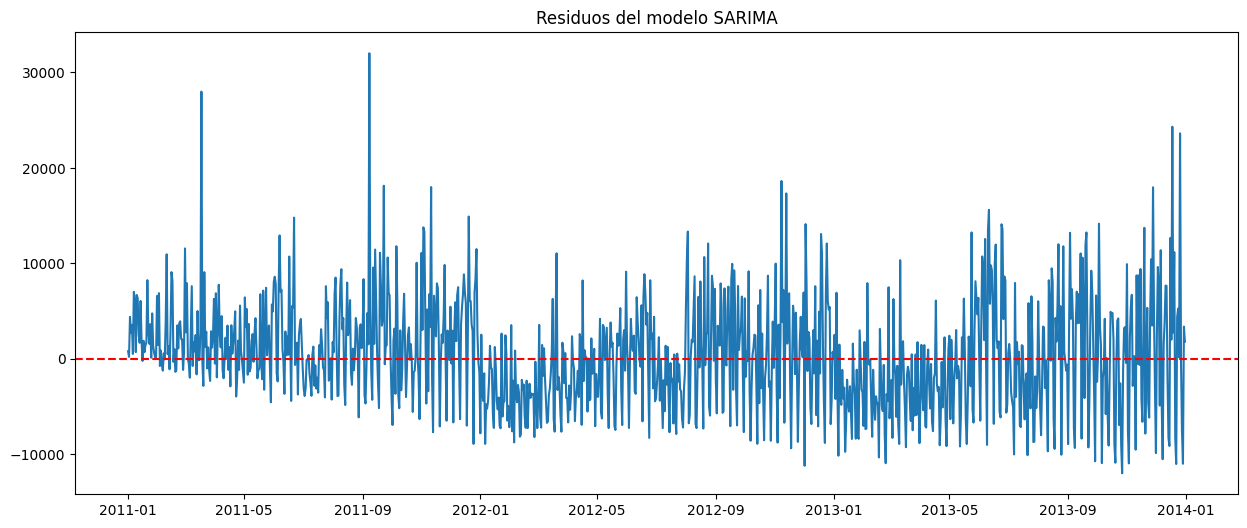

Prueba de Ljung-Box para residuos:
    lb_stat  lb_pvalue
10   485.27       0.00
                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                 1096
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -10931.524
Date:                            Sun, 17 Nov 2024   AIC                          21875.048
Time:                                    19:52:19   BIC                          21904.895
Sample:                                01-01-2011   HQIC                         21886.356
                                     - 12-31-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0079      1.408 

c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

In [ ]:
import seaborn as sns

# Paso 1: Inspección de datos
plt.figure(figsize=(15, 6))
sns.lineplot(data=train_daily, label='Datos de entrenamiento')
sns.lineplot(data=test.set_index('Order Date')['Sales'], label='Datos reales de prueba')
plt.title('Series temporal - Datos de entrenamiento y prueba')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

# Detectar valores atípicos
outliers = train_daily[train_daily > train_daily.mean() + 3 * train_daily.std()]
print('Valores atípicos detectados:', outliers)

# Paso 2: Diagnóstico del modelo ajustado
residuals = sarima_fit.resid
plt.figure(figsize=(15, 6))
plt.plot(residuals)
plt.title('Residuos del modelo SARIMA')
plt.axhline(0, linestyle='--', color='red')
plt.show()

# Verificar si los residuos son ruido blanco
from statsmodels.stats.diagnostic import acorr_ljungbox

ljungbox_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print('Prueba de Ljung-Box para residuos:')
print(ljungbox_test)

# Paso 3: Ajustar un nuevo modelo SARIMA con mejores parámetros
new_sarima_model = SARIMAX(train_daily, 
                           order=(1, 1, 1),  # Modelo ARIMA más completo
                           seasonal_order=(1, 1, 1, 12),  # Captura estacionalidad
                           trend='c',
                           enforce_stationarity=False, 
                           enforce_invertibility=False)

new_sarima_fit = new_sarima_model.fit(disp=False)
print(new_sarima_fit.summary())

# Paso 4: Predicción paso a paso (rolling forecast)
forecast_rolling = []
history = list(train_daily)

for t in range(len(test)):
    model = SARIMAX(history, 
                    order=(1, 1, 1), 
                    seasonal_order=(1, 1, 1, 12), 
                    trend='c',
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    fit = model.fit(disp=False)
    forecast = fit.forecast(steps=1)
    forecast_rolling.append(forecast[0])
    history.append(test.iloc[t]['Sales'])  # Actualizar con dato real

# Comparar con datos reales
from sklearn.metrics import mean_squared_error

rmse_rolling = np.sqrt(mean_squared_error(test['Sales'], forecast_rolling))
print(f'RMSE del modelo mejorado (rolling forecast) para 2014: {rmse_rolling}')

# Paso 5: Predicción extendida para 2015
forecast_2015 = new_sarima_fit.get_forecast(steps=365)
forecast_2015_mean = forecast_2015.predicted_mean

# Graficar los resultados
plt.figure(figsize=(15, 6))
plt.plot(test.set_index('Order Date')['Sales'], label='Datos reales 2014')
plt.plot(forecast_rolling, label='Predicción 2014 (rolling forecast)', linestyle='--')
plt.plot(forecast_2015_mean, label='Predicción 2015', linestyle='--')
plt.title('Predicciones mejoradas para 2014 y 2015')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

# Paso 6: Comparación de cifras anuales
pred_annual_sales_2014 = np.sum(forecast_rolling)
print(f'Cifra anual predicha para 2014 (mejorada): {pred_annual_sales_2014:,.2f}')

pred_annual_sales_2015 = forecast_2015_mean.sum()
print(f'Cifra anual predicha para 2015: {pred_annual_sales_2015:,.2f}')
